In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd

tensor([[-0.2676,  0.4229],
        [ 0.6260,  0.5280],
        [ 0.6940,  0.1438],
        [ 0.2216,  0.4725],
        [ 0.0386, -0.2555]])
tensor([-0.3276,  0.3993, -0.4266,  0.4338, -0.1118])
tensor([[ 0.0495, -0.3057,  0.0810,  0.3570, -0.1599],
        [ 0.3512,  0.3600, -0.0753,  0.4386,  0.2538],
        [ 0.2612, -0.2190,  0.3135,  0.0286, -0.4233],
        [ 0.1242, -0.0727, -0.2909,  0.3707, -0.1888],
        [ 0.2982,  0.0190,  0.3751,  0.2068, -0.3729],
        [-0.2388, -0.1040, -0.2667,  0.3028, -0.2436],
        [-0.4357, -0.2670, -0.2931,  0.3478,  0.2851]])
tensor([ 0.0057,  0.1995,  0.0829, -0.1526, -0.2017, -0.0833, -0.3482])
tensor([[ 0.1787, -0.3278, -0.0784, -0.1474, -0.2739, -0.3319, -0.1261],
        [-0.2006,  0.1363,  0.3274,  0.2630,  0.3415,  0.0157, -0.2306],
        [ 0.0186,  0.1734, -0.0446,  0.0913,  0.0252, -0.1360,  0.0888],
        [-0.2462, -0.1242, -0.2335,  0.2061,  0.0063,  0.0057,  0.0437],
        [-0.3164, -0.0014, -0.1261, -0.3092,  0.2205, -

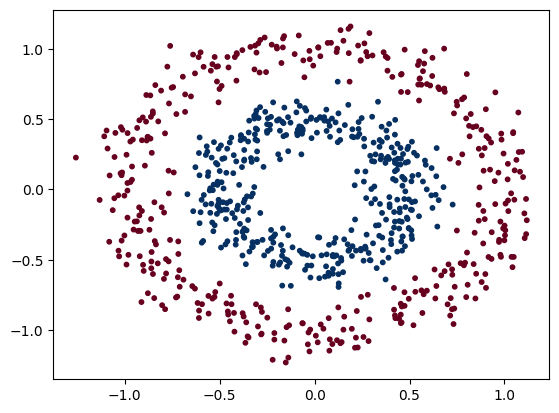

In [6]:
# Create a circles dataset
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

# Plot data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.RdBu)

In [7]:
# Define the overly complicated MLP
# class LargeMLP(nn.Module):
#     def __init__(self):
#         super(LargeMLP, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(2, 5),
#             nn.ReLU(),
#             nn.Linear(5, 6),
#             nn.ReLU(),
#             nn.Linear(6, 5),
#             nn.ReLU(),
#             nn.Linear(5, 7),
#             nn.ReLU(),
#             nn.Linear(7, 2),
#             # nn.ReLU()
#         )

#     def forward(self, x):
#         model.layers()
#         return self.layers(x)

model = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 7),
    nn.ReLU(),
    nn.Linear(7, 6),
    nn.ReLU(),
    nn.Linear(6, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.Sigmoid()
)

print(model)
model_cpy = copy.deepcopy(model)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=4, bias=True)
  (7): ReLU()
  (8): Linear(in_features=4, out_features=2, bias=True)
  (9): Sigmoid()
)


In [8]:
for name, param in model.named_parameters():
	if param.requires_grad:
		print(param)

Parameter containing:
tensor([[ 0.4761, -0.2701],
        [-0.4899,  0.4774],
        [-0.4797, -0.4850],
        [ 0.6816,  0.3083],
        [-0.6699, -0.0798]], requires_grad=True)
Parameter containing:
tensor([-0.1125, -0.0657,  0.5509,  0.2437, -0.5567], requires_grad=True)
Parameter containing:
tensor([[ 0.2945,  0.3504,  0.3604, -0.4366,  0.1370],
        [ 0.2227,  0.2241, -0.2622, -0.1447,  0.2020],
        [ 0.3661,  0.0622, -0.2026, -0.1028,  0.3925],
        [-0.0490,  0.1049,  0.1246, -0.3407,  0.3424],
        [-0.2802, -0.3516, -0.0482, -0.4203, -0.2303],
        [-0.2005,  0.3478, -0.2544,  0.4282, -0.3080],
        [ 0.3892,  0.4279, -0.3395,  0.0975, -0.2891]], requires_grad=True)
Parameter containing:
tensor([ 0.0831, -0.2130, -0.3718, -0.1019,  0.0381, -0.0245, -0.0852],
       requires_grad=True)
Parameter containing:
tensor([[ 0.1874, -0.0549,  0.2464, -0.3406, -0.0506, -0.1417,  0.3607],
        [-0.0042,  0.1164,  0.1349,  0.1064,  0.3182, -0.0212, -0.2674],
    

In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [100/1000], Loss: 0.3179, Val Loss: 0.3409
Epoch [200/1000], Loss: 0.3153, Val Loss: 0.3361
Epoch [300/1000], Loss: 0.3145, Val Loss: 0.3359
Epoch [400/1000], Loss: 0.3140, Val Loss: 0.3364
Epoch [500/1000], Loss: 0.3137, Val Loss: 0.3366
Epoch [600/1000], Loss: 0.3136, Val Loss: 0.3366
Epoch [700/1000], Loss: 0.3135, Val Loss: 0.3367
Epoch [800/1000], Loss: 0.3134, Val Loss: 0.3367
Epoch [900/1000], Loss: 0.3134, Val Loss: 0.3370
Epoch [1000/1000], Loss: 0.3133, Val Loss: 0.3368


In [10]:
torch.save(model.state_dict(), 'model.pickle')

In [11]:
# torch.unique(model(X_val_tensor))
y_val_outputs = model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

0.975

In [12]:
# # Apply L1 structured pruning
# from torch.nn.utils import prune

# # Specify the amount of pruning
# amount = 0.5

# # Prune the model
# for module in model.layers:
#     if isinstance(module, nn.Linear):
#         prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)

# # Print sparsity of each layer
# for module in model.layers:
#     if isinstance(module, nn.Linear):
#         print(f"Sparsity in {module}: {100. * float(torch.sum(module.weight == 0)) / float(module.weight.nelement()):.2f}%")


In [13]:
prune_ratio = 0.2
pruned_model = nn.Sequential()
pruned_layers = []
input_shape = 2
layer_index = 0
for name, param in model.named_parameters():
	if 'weight' in name:
		if param.shape[0] == 2:
			layer = nn.Linear(input_shape, 2)
			with torch.no_grad():
				layer.data = model_cpy[layer_index].weight.data
			pruned_layers.append(layer)
			pruned_layers.append(nn.Sigmoid())
			continue
		sorted_layers = torch.linalg.norm(param.data, ord=1, dim=1).argsort(dim=-1)
		print(sorted_layers)
		layers_not_pruned = sorted(sorted_layers[int(prune_ratio*param.data.shape[0]):])
		print(layers_not_pruned)
		#layer_data = param.data[layers_not_pruned,:]
		layer_data = model_cpy[layer_index].weight.data[layers_not_pruned, :] #initialising unpruned neurons with pre-trainied values
		layer = nn.Linear(input_shape, layer_data.shape[0])
		input_shape = layer_data.shape[0]
		with torch.no_grad():
			layer.data = layer_data
		pruned_layers.append(layer)
		pruned_layers.append(nn.ReLU())
		layer_index=layer_index+2	#skipping every alternate relu layer

print(pruned_layers)
pruned_model = nn.Sequential(*pruned_layers)
print(pruned_model[0].data)

tensor([0, 4, 1, 3, 2])
[tensor(1), tensor(2), tensor(3), tensor(4)]
tensor([1, 2, 6, 3, 4, 0, 5])
[tensor(0), tensor(2), tensor(3), tensor(4), tensor(5), tensor(6)]
tensor([2, 3, 1, 0, 5, 4])
[tensor(0), tensor(1), tensor(3), tensor(4), tensor(5)]
tensor([1, 0, 3, 2])
[tensor(0), tensor(1), tensor(2), tensor(3)]
[Linear(in_features=2, out_features=4, bias=True), ReLU(), Linear(in_features=4, out_features=6, bias=True), ReLU(), Linear(in_features=6, out_features=5, bias=True), ReLU(), Linear(in_features=5, out_features=4, bias=True), ReLU(), Linear(in_features=4, out_features=2, bias=True), Sigmoid()]
tensor([[-0.4899,  0.4774],
        [-0.4797, -0.4850],
        [ 0.6816,  0.3083],
        [-0.6699, -0.0798]])


In [14]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pruned_model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    # model.train()
    outputs = pruned_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        pruned_model.eval()
        with torch.no_grad():
            val_outputs = pruned_model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [100/1000], Loss: 0.4144, Val Loss: 0.4212
Epoch [200/1000], Loss: 0.3463, Val Loss: 0.3579
Epoch [300/1000], Loss: 0.3331, Val Loss: 0.3494
Epoch [400/1000], Loss: 0.3269, Val Loss: 0.3482
Epoch [500/1000], Loss: 0.3233, Val Loss: 0.3474
Epoch [600/1000], Loss: 0.3212, Val Loss: 0.3465
Epoch [700/1000], Loss: 0.3199, Val Loss: 0.3469
Epoch [800/1000], Loss: 0.3188, Val Loss: 0.3468
Epoch [900/1000], Loss: 0.3181, Val Loss: 0.3470
Epoch [1000/1000], Loss: 0.3175, Val Loss: 0.3470


In [15]:
# torch.unique(model(X_val_tensor))
y_val_outputs = pruned_model(X_val_tensor).argmax(dim=-1)
(y_val_outputs == y_val_tensor).sum().item() / len(y_val_tensor)

0.965

# Regression, Reliability

Epoch [100/1000], Loss: 91.0993, Val Loss: 90.0911
Epoch [200/1000], Loss: 26.5138, Val Loss: 26.1577
Epoch [300/1000], Loss: 6.4684, Val Loss: 6.3785
Epoch [400/1000], Loss: 2.0463, Val Loss: 2.0305
Epoch [500/1000], Loss: 1.3561, Val Loss: 1.3541
Epoch [600/1000], Loss: 1.2662, Val Loss: 1.2659
Epoch [700/1000], Loss: 1.2417, Val Loss: 1.2415
Epoch [800/1000], Loss: 1.2221, Val Loss: 1.2219
Epoch [900/1000], Loss: 1.2031, Val Loss: 1.2029
Epoch [1000/1000], Loss: 1.1849, Val Loss: 1.1847


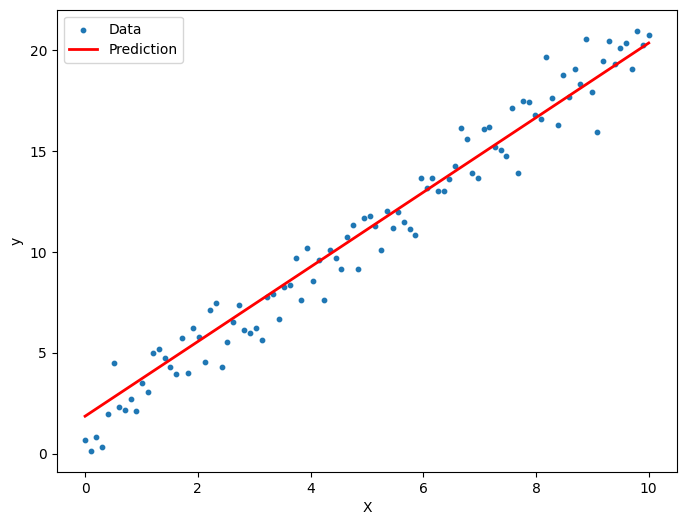

In [16]:
# Linear Regression dataset using PyTorch tensors
X = np.linspace(0, 10, 100)
y = 2*X + 1 + np.random.normal(0, 1, *X.shape)

# NN model for linear Regression
model = nn.Sequential(
    nn.Linear(1, 1)
)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X.reshape(-1, 1))
y_train_tensor = torch.FloatTensor(y.reshape(-1, 1))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_train_tensor)
            val_loss = criterion(val_outputs, y_train_tensor)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot the data and the model prediction
plt.figure(figsize=(8, 6))
plt.scatter(X, y, s=10, label='Data')
plt.plot(X, model(X_train_tensor).detach().numpy(), color='red', linewidth=2, label='Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

0     0.116811
1     0.028863
2     0.079339
3     0.019318
4     0.257402
        ...   
95    0.776961
96    0.239022
97    0.836988
98    0.538125
99    0.651942
Name: perc, Length: 100, dtype: float64
0    -1.191081
1    -1.897770
2    -1.409532
3    -2.068050
4    -0.651377
        ...   
95    0.761969
96   -0.709452
97    0.982155
98    0.095711
99    0.390568
Name: z, Length: 100, dtype: float64


AttributeError: 'Figure' object has no attribute 'close'

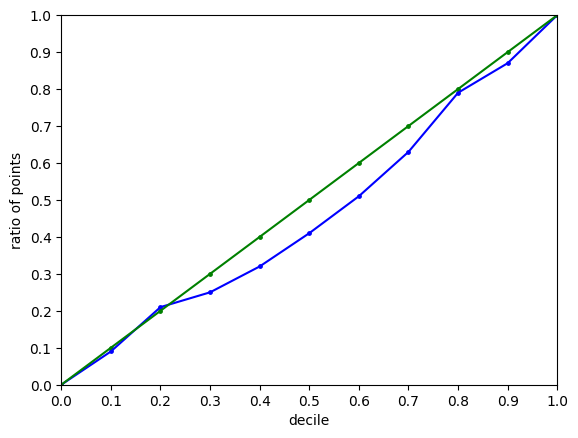

In [17]:
import scipy.stats as st

def reliability_diagram(mean, sigma, Y, color="blue", label="Model", marker_size=6):
    fig, ax = plt.subplots()
    df = pd.DataFrame()
    df["mean"] = mean
    df["sigma"] = sigma
    df["Y"] = Y
    df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
    df["perc"] = st.norm.cdf(df["z"])
    print(df["perc"])
    print(df["z"])
    k = np.arange(0, 1.1, 0.1)
    counts = []
    df2 = pd.DataFrame()
    df2["Interval"] = k
    df2["Ideal"] = k
    for i in range(0, 11):
        l = df[df["perc"] < 0.5 + i * 0.05]
        l = l[l["perc"] >= 0.5 - i * 0.05]
        counts.append(len(l) / len(df))
    df2["Counts"] = counts

    ax.plot(k, counts, color=color, label=label)

    ax.scatter(k, counts, color=color,s=marker_size)
    ax.scatter(k, k,color="green",s=marker_size)
    ax.set_yticks(k)
    ax.set_xticks(k)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    # ax.legend()
    ax.set_xlabel("decile")
    ax.set_ylabel("ratio of points")
    ax.plot(k, k, color="green")

predictions = model(X_train_tensor).detach().numpy().reshape(-1,)
# print(predictions)
# y_pred = y_pred.detach().numpy()

true_labels = y_train_tensor.detach().numpy().reshape(-1,)
# print(true_labels)

sigma = np.ones((len(predictions),))

reliability_diagram(predictions, sigma, true_labels)
plt.show()


In [18]:
import scipy.stats as st

st.norm.ppf(0.5)

0.0